In [4]:
import pandas as pd
import numpy as np
file_path = '/Users/z/Desktop/Mathor/数据.xlsx'
df = pd.read_excel(file_path)

In [5]:
# 过滤不符合条件的经纬度数据
df = df[(df['经度'] >= 95 ) & (df['经度'] <= 180) & (df['纬度'] >= 2) & (df['纬度'] <= 58)]
df = df[(df['气压'] > 100 ) & (df['风速'] <= 100)]

In [6]:
import pandas as pd

def convert_direction(direction):
    # 如果移动方向为空，直接返回空
    if pd.isnull(direction):
        return direction
    
    # 创建字符到数值的映射
    char_mapping = {
        '东': '1',
        '南': '2',
        '西': '3',
        '北': '4',
        '偏': '0',  
        'E': '1',
        'S': '2',
        'W': '3',
        'N': '4',
    }
    
    # 初始化转换结果
    converted = ''
    
    # 逐个字符转换，忽略“偏”字
    for char in direction:
        if char in char_mapping:
            converted += char_mapping[char]
    
    # 返回转换后的结果
    return converted

# 应用转换函数
df['移动方向数值'] = df['移动方向'].apply(convert_direction)

# 如果需要将新列放到原列后面
current_direction_index = df.columns.get_loc('移动方向')
df.insert(current_direction_index + 1, '移动方向数值', df.pop('移动方向数值'))

In [7]:
# 假设你要转换的列名为 '台风起始时间', '台风结束时间', '当前台风时间'
df['台风起始时间'] = pd.to_datetime(df['台风起始时间'])
df['台风结束时间'] = pd.to_datetime(df['台风结束时间'])
df['当前台风时间'] = pd.to_datetime(df['当前台风时间'])

In [8]:
# 提取年份
df['年份'] = df['当前台风时间'].dt.year
df['月份'] = df['当前台风时间'].dt.month
# 定义一个函数将经纬度转换为以.5结尾的值
def convert_to_half(value):
    if value % 1 < 0.25:  # 小于 x.25
        return np.floor(value) + 0.5
    elif value % 1 < 0.75:  # 在 x.25 和 x.75 之间
        return np.floor(value) + 0.5
    else:  # 大于等于 x.75
        return np.ceil(value) - 0.5

# 应用函数转换经纬度
df['调整后的经度'] = df['经度'].apply(convert_to_half)
df['调整后的纬度'] = df['纬度'].apply(convert_to_half)

# 根据年份分类
grouped = df.groupby('年份')[['调整后的经度', '调整后的纬度']].apply(lambda x: x.reset_index(drop=True))

In [9]:
# 替换台风强度中的“超强台风（Super TY）”为“超强台风（SuperTY）”
df['台风强度'] = df['台风强度'].replace('超强台风(Super TY)', '超强台风(SuperTY)')

# 剔除年份为1945的行
df = df[df['年份'] != 1945]

In [10]:
# 计算气压值不为0的平均值
pressure_mean = df.loc[df['气压'] != 0, '气压'].mean()
# 使用 loc 来进行替换，以避免警告
df.loc[df['气压'] == 0, '气压'] = pressure_mean

In [11]:
# 检查每列的空值数量
missing_data = df.isnull().sum()
# 查看台风强度的唯一类别
unique_intensity_categories = df['台风强度'].unique()

In [12]:
import pandas as pd

# 假设 df 是你的 DataFrame，且风速列名为 '风速'
# 定义风速的区间和对应的台风强度类别
bins = [-1, 10.8, 17.1, 24.4, 32.6, 41.4, 50.9, float('inf')]
labels = ['弱热带低压或未知', '热带低压（TD）', '热带风暴（TS）', '强热带风暴（STS）', '台风（TY）', '强台风（STY）', '超强台风（SuperTY）']

# 仅针对“台风强度”为 NaN 且“风速”不为空或不为零的行进行分类
mask = df['台风强度'].isnull() & (df['风速'].notnull() & (df['风速'] > 0))

# 使用 cut() 方法根据风速分类
df.loc[mask, '台风强度'] = pd.cut(df.loc[mask, '风速'], bins=bins, labels=labels)

In [13]:
# 对海洋表面温度的空缺值进行插值填补
df['海洋表面温度'] = df['海洋表面温度'].interpolate(method='linear')

# 如果想使用其他插值方法，比如时间插值(需要时间索引)可以使用：
 #df['海洋表面温度'] = df['海洋表面温度'].interpolate(method='time')
df['气压'] = df['气压'].interpolate(method='linear')# 对气压的空缺值进行线性插值
# 通过布尔条件剔除台风强度和风速均为零或空值的行
df = df[~((df['台风强度'].isnull() | (df['台风强度'] == 0)) & 
           (df['风速'].isnull() | (df['风速'] == 0)))]

In [14]:
# 创建台风强度的映射
typhoon_intensity_mapping = {
    '弱热带低压或未知': 0,
    '热带低压(TD)': 1,
    '热带风暴(TS)': 2,
    '强热带风暴(STS)': 3,
    '台风(TY)': 4,
    '强台风(STY)': 5,
    '超强台风(SuperTY)': 6,
}

# 将台风强度列转换为数值并保留原列
df['台风强度数值'] = df['台风强度'].map(typhoon_intensity_mapping)
current_intensity_index = df.columns.get_loc('台风强度')
df.insert(current_intensity_index + 1, '台风强度数值', df.pop('台风强度数值'))

In [15]:
# 将时间格式化为所需的字符串格式
df['格式化时间'] = df['当前台风时间'].dt.strftime('%Y%m%d%H')
# 获取 '当前台风时间' 的列索引
current_time_index = df.columns.get_loc('当前台风时间')

# 将 '格式化时间' 列插入到 '当前台风时间' 的后面
df.insert(current_time_index + 1, '格式化时间', df.pop('格式化时间'))

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 筛选1970到2020年的数据
df['当前台风时间'] = pd.to_datetime(df['当前台风时间'])
filtered_df = df[(df['当前台风时间'].dt.year >= 1970) & (df['当前台风时间'].dt.year <= 2020)]

# 转换时间为步长，并将其加入到特征中
filtered_df.loc[:, '时间步长'] = (filtered_df['当前台风时间'] - filtered_df['当前台风时间'].min()).dt.total_seconds() / 21600  # 每6小时一次，转换为时间步长

# 使用经度、纬度和时间步长作为输入
data = filtered_df[['经度', '纬度', '时间步长']].values
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# 创建数据集
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, :2])  # 目标是经度和纬度
    return np.array(X), np.array(y)

# 创建输入数据集
X, y = create_dataset(data, time_step=10)

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 固定超参数
learning_rate = 0.001
dropout_rate = 0.3
batch_size = 32
epochs = 100

# 创建LSTM模型
def create_lstm_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2))  # 预测经度和纬度
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 创建并训练模型
model = create_lstm_model(learning_rate, dropout_rate)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(patience=10)])

# 使用模型对测试集进行预测
y_pred = model.predict(X_test)

# 计算评估指标
mse_longitude = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_latitude = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_longitude = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_latitude = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_longitude = r2_score(y_test[:, 0], y_pred[:, 0])
r2_latitude = r2_score(y_test[:, 1], y_pred[:, 1])

print(f"Mean Squared Error (MSE) - Longitude: {mse_longitude}")
print(f"Mean Squared Error (MSE) - Latitude: {mse_latitude}")
print(f"Mean Absolute Error (MAE) - Longitude: {mae_longitude}")
print(f"Mean Absolute Error (MAE) - Latitude: {mae_latitude}")
print(f"R-squared (R2) - Longitude: {r2_longitude}")
print(f"R-squared (R2) - Latitude: {r2_latitude}")

# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='valid_loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("LSTM模型经纬度损失曲线.png", format="png", dpi=600, bbox_inches='tight')
plt.show()


C:\Users\z\AppData\Local\Temp\ipykernel_36892\3041142917.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, '时间步长'] = (filtered_df['当前台风时间'] - filtered_df['当前台风时间'].min()).dt.total_seconds() / 21600  # 每6小时一次，转换为时间步长
C:\Users\z\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0155 - val_loss: 0.0034
Epoch 2/100
 431/1182 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0054


KeyboardInterrupt



In [70]:
# 读取贝碧嘉台风数据
df_BEBINCA = pd.read_excel('贝碧嘉数据.xlsx')
# 转换时间列为日期时间格式
df_BEBINCA['时间'] = pd.to_datetime(df_BEBINCA['时间'])
# 转换时间为步长，并将其加入到特征中
df_BEBINCA['时间步长'] = (df_BEBINCA['时间'] - df_BEBINCA['时间'].min()).dt.total_seconds() / 21600  # 每6小时一次，转换为时间步长
# 使用经度、纬度和时间步长作为输入
data_BEBINCA = df_BEBINCA[['经度', '纬度', '时间步长']].values
data_BEBINCA = scaler.transform(data_BEBINCA)  # 使用之前的缩放器进行缩放
# 创建输入数据集
X_BEBINCA, _ = create_dataset(data_BEBINCA, time_step=10)  # 不需要返回y
# 使用训练好的模型进行预测
y_BEBINCA_pred = model.predict(X_BEBINCA)
# 将预测结果转换回原始尺度（经度和纬度）
# 因为你要预测经度和纬度，所以创建一个合适的数组
predictions_unscaled = scaler.inverse_transform(np.concatenate((y_BEBINCA_pred, np.zeros((y_BEBINCA_pred.shape[0], 1))), axis=1))
# 提取经度和纬度
y_BEBINCA_pred_longitude = predictions_unscaled[:, 0]
y_BEBINCA_pred_latitude = predictions_unscaled[:, 1]
# 输出预测结果
df_BEBINCA['预测经度'] = np.nan
df_BEBINCA['预测纬度'] = np.nan
# 确保预测结果放置在正确的位置
start_index = 10  # 从第10个位置开始填充预测结果
df_BEBINCA.iloc[start_index:start_index + len(y_BEBINCA_pred), df_BEBINCA.columns.get_loc('预测经度')] = y_BEBINCA_pred_longitude
df_BEBINCA.iloc[start_index:start_index + len(y_BEBINCA_pred), df_BEBINCA.columns.get_loc('预测纬度')] = y_BEBINCA_pred_latitude
# 打印预测结果
print(df_BEBINCA[['时间', '经度', '纬度', '预测经度', '预测纬度']])

# 保存结果到 Excel 文件
output_file = 'LSTM贝碧嘉预测结果.xlsx'
df_BEBINCA.to_excel(output_file, index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
                    时间     经度    纬度        预测经度       预测纬度
0  2024-09-10 00:00:00  146.8  10.8         NaN        NaN
1  2024-09-10 03:00:00  146.2  11.2         NaN        NaN
2  2024-09-10 06:00:00  145.7  11.6         NaN        NaN
3  2024-09-10 09:00:00  145.5  12.1         NaN        NaN
4  2024-09-10 12:00:00  145.4  12.6         NaN        NaN
..                 ...    ...   ...         ...        ...
67 2024-09-18 09:00:00  115.0  33.5  118.871502  31.578294
68 2024-09-18 12:00:00  114.8  33.5  118.874838  31.503609
69 2024-09-18 15:00:00  114.8  33.4  118.813413  31.412956
70 2024-09-18 18:00:00  114.9  33.2  118.858849  31.254695
71 2024-09-18 20:00:00  114.9  32.7  118.932631  31.030578

[72 rows x 5 columns]


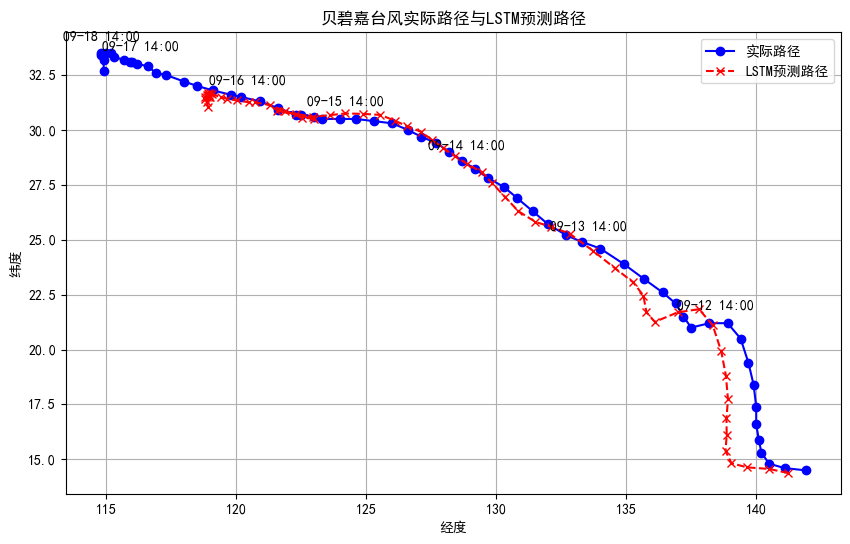

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 使负号显示正常

# 1. 读取 LSTM 预测结果 Excel 文件
lstm_file_path = "C:\\Users\\z\\Desktop\\Mathor\\LSTM贝碧嘉预测结果.xlsx"
lstm_data = pd.read_excel(lstm_file_path)

# 假设 Excel 文件包含以下列：实际经度、实际纬度、LSTM预测经度、LSTM预测纬度、时间
# 根据你的文件实际列名来调整
actual_lon_lstm = lstm_data['经度']
actual_lat_lstm = lstm_data['纬度']
lstm_predicted_lon = lstm_data['预测经度']
lstm_predicted_lat = lstm_data['预测纬度']
time_lstm = pd.to_datetime(lstm_data['时间'])

# 2. 插值处理
# 提取 2024年9月12日到2024年9月18日的日期和对应的时间
target_dates = [datetime.datetime(2024, 9, day, 14, 0) for day in range(12, 19)]
target_times_numeric = [(target_date - datetime.datetime(1970, 1, 1)).total_seconds() for target_date in target_dates]

# 转换时间为浮点数形式（时间戳）
time_numeric_lstm = time_lstm.astype(np.int64) / 1e9  # 转换为秒

# 使用线性插值
interp_actual_lon_lstm = interp1d(time_numeric_lstm, actual_lon_lstm, fill_value="extrapolate")
interp_actual_lat_lstm = interp1d(time_numeric_lstm, actual_lat_lstm, fill_value="extrapolate")
interp_lstm_predicted_lon = interp1d(time_numeric_lstm, lstm_predicted_lon, fill_value="extrapolate")
interp_lstm_predicted_lat = interp1d(time_numeric_lstm, lstm_predicted_lat, fill_value="extrapolate")

# 获取插值结果
interp_actual_lon_values_lstm = interp_actual_lon_lstm(target_times_numeric)
interp_actual_lat_values_lstm = interp_actual_lat_lstm(target_times_numeric)
interp_lstm_predicted_lon_values = interp_lstm_predicted_lon(target_times_numeric)
interp_lstm_predicted_lat_values = interp_lstm_predicted_lat(target_times_numeric)

# 3. 绘图
plt.figure(figsize=(10, 6))

# 找到预测经度和纬度都存在值的起始索引
valid_start_index = None
for i in range(len(lstm_predicted_lon)):
    if not pd.isnull(lstm_predicted_lon[i]) and not pd.isnull(lstm_predicted_lat[i]):
        valid_start_index = i
        break

# 如果找到了有效的起始索引
if valid_start_index is not None:
    # 只绘制从有效起始索引开始的数据
    plt.plot(actual_lon_lstm[valid_start_index:], actual_lat_lstm[valid_start_index:], label='实际路径', color='blue', marker='o')
    plt.plot(lstm_predicted_lon[valid_start_index:], lstm_predicted_lat[valid_start_index:], label='LSTM预测路径', color='red', linestyle='--', marker='x')
    # 添加时间标记
    for i, txt in enumerate(target_dates):
        plt.annotate(txt.strftime('%m-%d %H:%M'), (interp_actual_lon_values_lstm[i], interp_actual_lat_values_lstm[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('贝碧嘉台风实际路径与LSTM预测路径')
plt.xlabel('经度')
plt.ylabel('纬度')
plt.legend()
plt.grid()
plt.savefig('贝碧嘉台风LSTM路径预测.png')
plt.show()

# 输出插值结果
interpolation_results_lstm = pd.DataFrame({
    '日期': target_dates,
    '插值经度（实际）': interp_actual_lon_values_lstm,
    '插值纬度（实际）': interp_actual_lat_values_lstm,
    '插值经度（LSTM）': interp_lstm_predicted_lon_values,
    '插值纬度（LSTM）': interp_lstm_predicted_lat_values
})

interpolation_results_lstm.to_excel('贝碧嘉台风LSTM插值结果.xlsx', index=False)


Index(['SID', '年份', '英文名称', '时间', '纬度', '经度', '风速', '气压', '时间步长', '预测经度',
       '预测纬度'],
      dtype='object')
经度的DTW距离: 12.3173


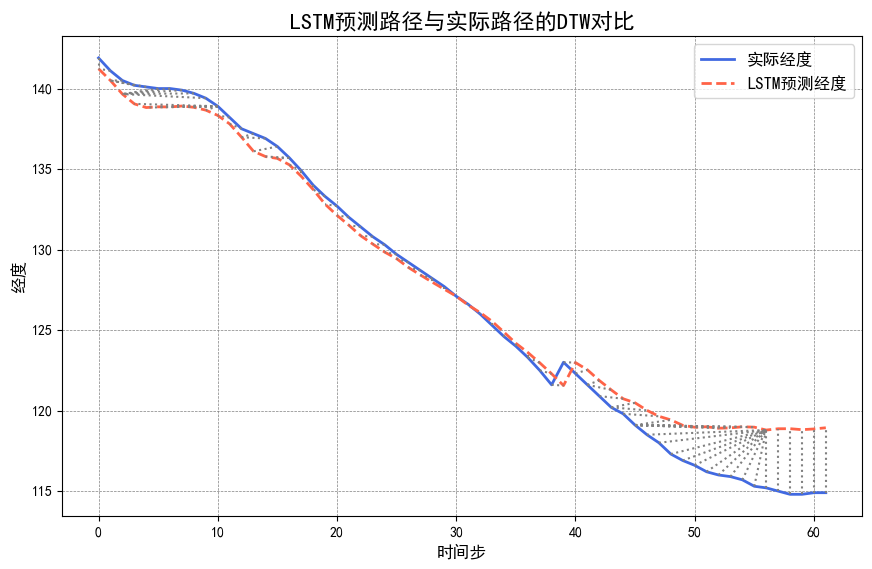

纬度的DTW距离: 6.3018


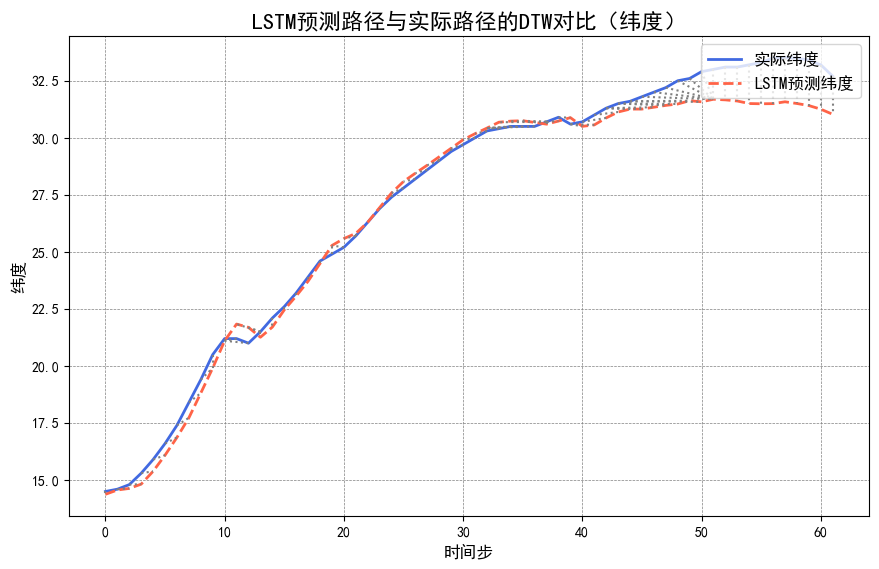

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw

# 1. 读取 LSTM 预测结果 Excel 文件
lstm_file_path = "C:\\Users\\z\\Desktop\\Mathor\\LSTM贝碧嘉预测结果.xlsx"
lstm_data = pd.read_excel(lstm_file_path)

# 打印列名以检查
print(lstm_data.columns)

# 假设 Excel 文件包含以下列：实际经度、实际纬度、LSTM预测经度、LSTM预测纬度、时间
actual_lon_lstm = lstm_data['经度']
actual_lat_lstm = lstm_data['纬度']
lstm_predicted_lon = lstm_data['预测经度']
lstm_predicted_lat = lstm_data['预测纬度']

# 2. 选择需要对比的有效路径（去除空值）
valid_indices = ~pd.isnull(actual_lon_lstm) & ~pd.isnull(lstm_predicted_lon)

actual_lon_valid = actual_lon_lstm[valid_indices].to_numpy()
predicted_lon_valid = lstm_predicted_lon[valid_indices].to_numpy()

# 3. 计算DTW距离
dtw_distance_lon = dtw.distance(actual_lon_valid, predicted_lon_valid)

# 输出DTW距离
print(f"经度的DTW距离: {dtw_distance_lon:.4f}")

# 4. 可视化DTW路径
alignment = dtw.warping_path(actual_lon_valid, predicted_lon_valid)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置字体和大小
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(actual_lon_valid, label='实际经度', color='royalblue', linewidth=2)
plt.plot(predicted_lon_valid, label='LSTM预测经度', color='tomato', linestyle='--', linewidth=2)

# 绘制DTW对齐路径
for (i, j) in alignment:
    plt.plot([i, j], [actual_lon_valid[i], predicted_lon_valid[j]], color='gray', linestyle='dotted')

plt.title('LSTM预测路径与实际路径的DTW对比', fontsize=16)
plt.xlabel('时间步', fontsize=12)
plt.ylabel('经度', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# 调整边距
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# 保存图像
plt.savefig('LSTM预测路径与实际路径DTW对比.png', dpi=500, bbox_inches='tight')
plt.show()

# 5. 计算纬度的DTW
# 选择有效路径
valid_lat_indices = ~pd.isnull(actual_lat_lstm) & ~pd.isnull(lstm_predicted_lat)

actual_lat_valid = actual_lat_lstm[valid_lat_indices].to_numpy()
predicted_lat_valid = lstm_predicted_lat[valid_lat_indices].to_numpy()

# 计算DTW距离
dtw_distance_lat = dtw.distance(actual_lat_valid, predicted_lat_valid)

# 输出DTW距离
print(f"纬度的DTW距离: {dtw_distance_lat:.4f}")

# 可视化纬度的DTW对比
alignment_lat = dtw.warping_path(actual_lat_valid, predicted_lat_valid)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(actual_lat_valid, label='实际纬度', color='royalblue', linewidth=2)
plt.plot(predicted_lat_valid, label='LSTM预测纬度', color='tomato', linestyle='--', linewidth=2)

# 绘制DTW对齐路径
for (i, j) in alignment_lat:
    plt.plot([i, j], [actual_lat_valid[i], predicted_lat_valid[j]], color='gray', linestyle='dotted')

plt.title('LSTM预测路径与实际路径的DTW对比（纬度）', fontsize=16)
plt.xlabel('时间步', fontsize=12)
plt.ylabel('纬度', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# 调整边距
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# 保存图像
plt.savefig('LSTM预测路径与实际路径DTW对比（纬度）.png', dpi=500, bbox_inches='tight')
plt.show()
